In [ ]:
! pip install ftfy regex tqdm
## CLIP
! pip install git+https://github.com/openai/CLIP.git

In [ ]:
## CLIPSurgery
! git clone https://github.com/xmed-lab/CLIP_Surgery.git

In [ ]:
## GAME
! git clone https://github.com/hila-chefer/Transformer-MM-Explainability.git
! mv Transformer-MM-Explainability/CLIP Game_MM_CLIP
! rm -rf Transformer-MM-Explainability

In [ ]:
## M2IB
! git clone https://github.com/YingWANGG/M2IB.git

In [1]:
import clip
import re
import torch
from tqdm import tqdm
from clip import tokenize
import cv2
import numpy as np
from torchvision.transforms import Resize
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

from urllib.request import urlopen

from generate_emap import clipmodel, preprocess, imgprocess_keepsize, mm_clipmodel, mm_interpret, \
        clip_encode_dense, grad_eclip, grad_cam, mask_clip, compute_rollout_attention, \
        surgery_model, clip_surgery_map, m2ib_model, m2ib_clip_map, \
        generate_masks, rise

## If Error: No module named 'scripts', change:
##   1. M2IB/scripts/methods: from scripts.iba import IBAInterpreter, Estimator --> from .iba import IBAInterpreter, Estimator
##   2. M2IB/scripts/iba: from scripts.utils import replace_layer, normalize, mySequential --> from .utils import replace_layer, normalize, mySequential

import Game_MM_CLIP.clip as mm_clip


device = "cuda" if torch.cuda.is_available() else "cpu"

/home/grads/chenyzhao9/anaconda3/envs/open_clip/lib/python3.8/site-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [2]:
import time
def pre_caption(caption, max_words=50):
    caption = re.sub(
        r"([.!\"()*#:;~])",       
        ' ',
        caption.lower(),
    )
    caption = re.sub(
        r"\s{2,}",
        ' ',
        caption,
    )
    caption = caption.rstrip('\n') 
    caption = caption.strip(' ')

    #truncate caption
    caption_words = caption.split(' ')
    if len(caption_words)>max_words:
        caption = ' '.join(caption_words[:max_words])
            
    return caption
    
def generate_hm(hm_type, img, txt_embedding, txts, resize):
    start = time.time()
    img_keepsized = imgprocess_keepsize(img).to(device).unsqueeze(0)
    outputs, v_final, last_input, v, q_out, k_out,\
        attn, att_output, map_size = clip_encode_dense(img_keepsized)
    img_embedding = F.normalize(outputs[:,0], dim=-1)
    cosines = (img_embedding @ txt_embedding.T)[0]

    if hm_type == "selfattn":
        emap = attn[0,:1,1:].detach().reshape(*map_size)
    elif "gradcam" in hm_type:
        emap = [grad_cam(c, last_input, map_size) for c in cosines]
        emap = torch.stack(emap, dim=0).sum(0)
    elif "maskclip" in hm_type:
        emap = mask_clip(txt_embedding.T, v_final, k_out, map_size)
        emap = emap.sum(0)
    elif "eclip" in hm_type:
        emap = [grad_eclip(c, q_out, k_out, v, att_output, map_size, withksim=False) \
            if "wo-ksim" in hm_type else grad_eclip(c, q_out, k_out, v, att_output, map_size, withksim=True) \
            for c in cosines]
        emap = torch.stack(emap, dim=0).sum(0)  
    elif "game" in hm_type:
        start = time.time()
        img_clipreprocess = preprocess(img).to(device).unsqueeze(0)
        text_tokenized = mm_clip.tokenize(txts).to(device)
        emap = mm_interpret(model=mm_clipmodel, image=img_clipreprocess, texts=text_tokenized, device=device)    
        emap = emap.sum(0) 
    elif "rollout" in hm_type:
        start = time.time()
        img_clipreprocess = preprocess(img).to(device).unsqueeze(0)
        text_tokenized = mm_clip.tokenize(txts).to(device)
        attentions = mm_interpret(model=mm_clipmodel, image=img_clipreprocess, texts=text_tokenized, device=device, rollout=True)      
        emap = compute_rollout_attention(attentions)[0]
    elif "surgery" in hm_type:
        start = time.time()
        img_clipreprocess = preprocess(img).to(device).unsqueeze(0)
        all_texts = ['airplane', 'bag', 'bed', 'bedclothes', 'bench', 'bicycle', 'bird', 'boat', 'book', 'bottle', 'building', 'bus', 'cabinet', 'car', 'cat', 'ceiling', 'chair', 'cloth', 'computer', 'cow', 'cup', 'curtain', 'dog', 'door', 'fence', 'floor', 'flower', 'food', 'grass', 'ground', 'horse', 'keyboard', 'light', 'motorbike', 'mountain', 'mouse', 'person', 'plate', 'platform', 'potted plant', 'road', 'rock', 'sheep', 'shelves', 'sidewalk', 'sign', 'sky', 'snow', 'sofa', 'table', 'track', 'train', 'tree', 'truck', 'tv monitor', 'wall', 'water', 'window', 'wood']
        all_texts = txts + all_texts
        emap = clip_surgery_map(model=surgery_model, image=img_clipreprocess, texts=all_texts, device=device)[0,:,:,0]
    elif "m2ib" in hm_type:
        start = time.time()
        img_clipreprocess = preprocess(img).to(device).unsqueeze(0)
        emap = m2ib_clip_map(model=m2ib_model, image=img_clipreprocess, texts=txts, device=device)
        emap = torch.tensor(emap)
    elif "rise" in hm_type:
        start = time.time()
        img_clipreprocess = preprocess(img).unsqueeze(0)
        emap = rise(model=clipmodel, image=img_clipreprocess, txt_embedding=txt_embedding, device=device)
        print(emap.shape)
    end = time.time()
    
    print("processing time: ", end-start)
    
    emap -= emap.min()
    emap /= emap.max()
    emap = resize(emap.unsqueeze(0))[0]
    return emap

def visualize(hmap, raw_image, resize):
    image = np.asarray(raw_image.copy())
    hmap = resize(hmap.unsqueeze(0))[0].cpu().numpy()
    color = cv2.applyColorMap((hmap*255).astype(np.uint8), cv2.COLORMAP_JET) # cv2 to plt
    color = cv2.cvtColor(color, cv2.COLOR_BGR2RGB)
    c_ret = np.clip(image * (1 - 0.5) + color * 0.5, 0, 255).astype(np.uint8)
    return c_ret

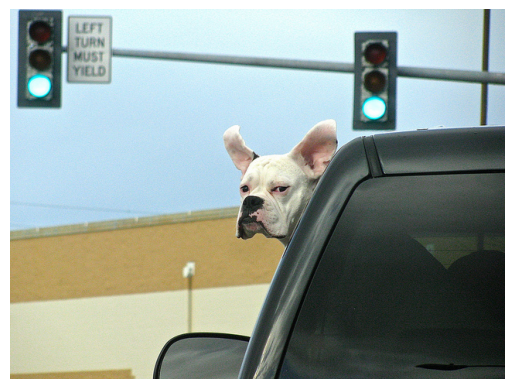

In [3]:
img_path = "./dog_and_car.png"
img = Image.open(img_path).convert("RGB")
caption = "a dog in a car waiting for traffic lights"

# url = "http://l7.alamy.com/zooms/1e7674256f464050bf142a5d21407ede/single-cowboy-guiding-a-line-of-horses-through-the-desert-bnh6m3.jpg"
# img = Image.open(urlopen(url))
# caption = "single cowboy guiding a line of horses through the desert"

plt.imshow(img)
plt.axis('off')
plt.show()

In [4]:
w, h = img.size
print(w,h)
resize = Resize((h,w))
                
text_processed = clip.tokenize([caption]).cuda()
# extract text featrue
text_embedding = clipmodel.encode_text(text_processed)
text_embedding = F.normalize(text_embedding, dim=-1)
print("[text embedding]:", text_embedding.shape)

640 478
[text embedding]: torch.Size([1, 512])


processing time:  0.032981157302856445


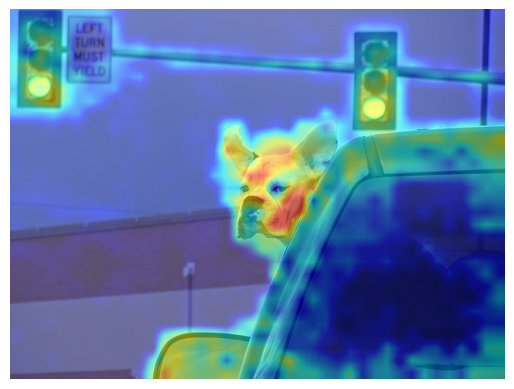

In [7]:
hm_type = 'eclip'
hm = generate_hm(hm_type, img, text_embedding, [caption], resize)
c_ret = visualize(hm, img.copy(), resize)
plt.imshow(c_ret)
plt.axis('off')
plt.show()

processing time:  0.018683671951293945


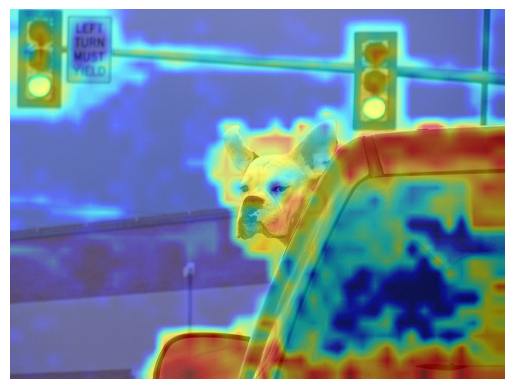

In [6]:
hm_type = 'eclip-wo-ksim'
hm = generate_hm(hm_type, img, text_embedding, [caption], resize)
c_ret = visualize(hm, img.copy(), resize)
plt.imshow(c_ret)
plt.axis('off')
plt.show()

processing time:  0.031124353408813477


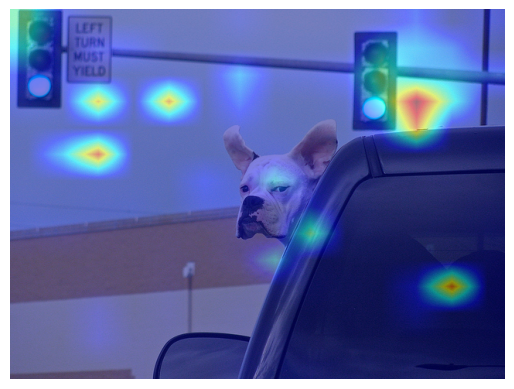

In [8]:
hm_type = 'game'
hm = generate_hm(hm_type, img, text_embedding, [caption], resize)
c_ret = visualize(hm, img.copy(), resize)
plt.imshow(c_ret)
plt.axis('off')
plt.show()

processing time:  0.019744157791137695


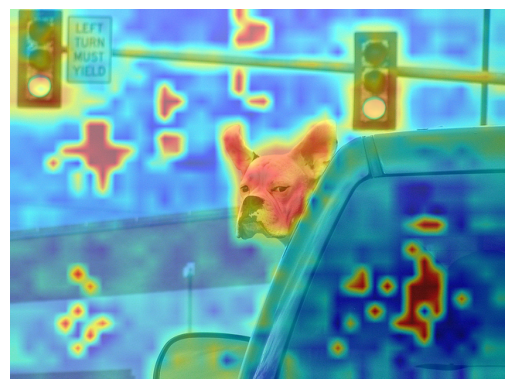

In [9]:
hm_type = 'maskclip'
hm = generate_hm(hm_type, img, text_embedding, [caption], resize)
c_ret = visualize(hm, img.copy(), resize)
plt.imshow(c_ret)
plt.axis('off')
plt.show()

processing time:  0.019186735153198242


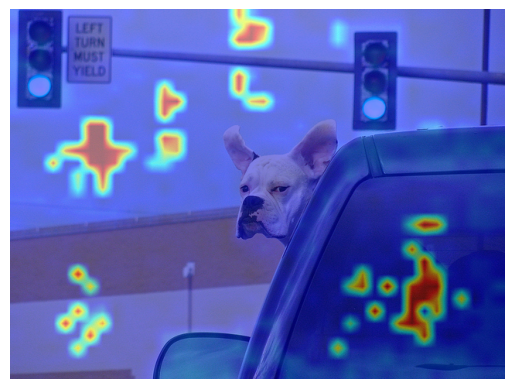

In [10]:
hm_type = 'gradcam'
hm = generate_hm(hm_type, img, text_embedding, [caption], resize)
c_ret = visualize(hm, img.copy(), resize)
plt.imshow(c_ret)
plt.axis('off')
plt.show()

processing time:  0.028885364532470703


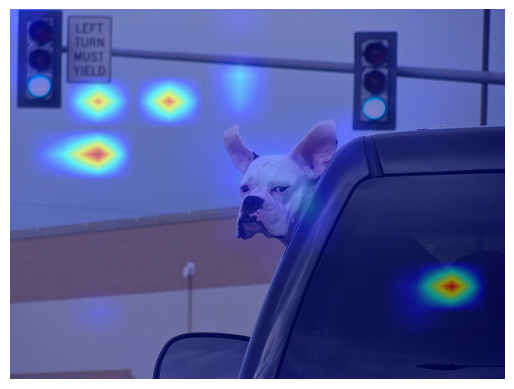

In [11]:
hm_type = 'rollout'
hm = generate_hm(hm_type, img, text_embedding, [caption], resize)
c_ret = visualize(hm, img.copy(), resize)
plt.imshow(c_ret)
plt.axis('off')
plt.show()

processing time:  0.026998519897460938


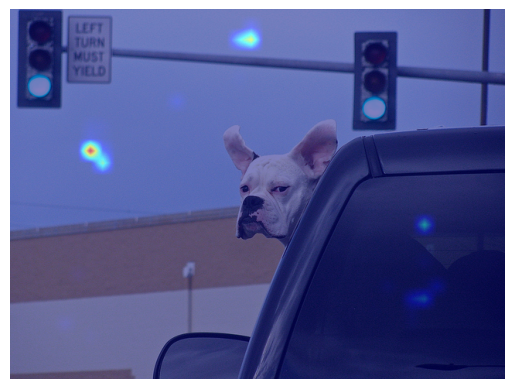

In [12]:
hm_type = 'selfattn'
hm = generate_hm(hm_type, img, text_embedding, [caption], resize)
c_ret = visualize(hm, img.copy(), resize)
plt.imshow(c_ret)
plt.axis('off')
plt.show()

processing time:  3.072824239730835


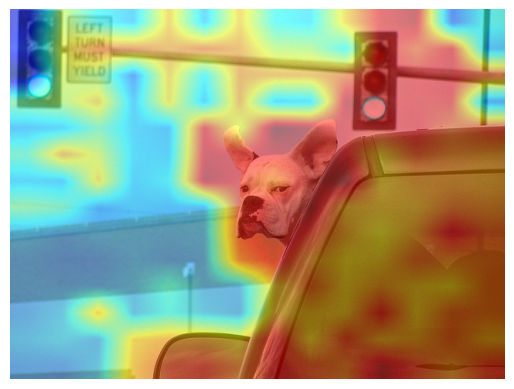

In [13]:
hm_type = 'surgery'
hm = generate_hm(hm_type, img, text_embedding, [caption], resize)
c_ret = visualize(hm, img.copy(), resize)
plt.imshow(c_ret)
plt.axis('off')
plt.show()

/opt/visal/home/chenyzhao9/projects/Grad-Eclip/M2IB/scripts/iba.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean, dtype=torch.float, device=self.device, requires_grad=False)
Training Bottleneck: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.76it/s]


processing time:  2.1300692558288574


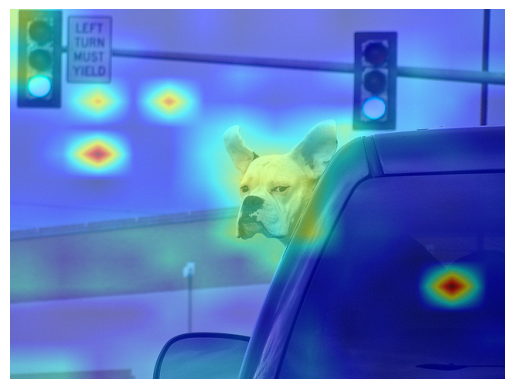

In [14]:
hm_type = 'm2ib'
hm = generate_hm(hm_type, img, text_embedding, caption, resize)
c_ret = visualize(hm, img.copy(), resize)
plt.imshow(c_ret)
plt.axis('off')
plt.show()

Explaining: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.34it/s]


torch.Size([224, 224])
processing time:  6.870073556900024


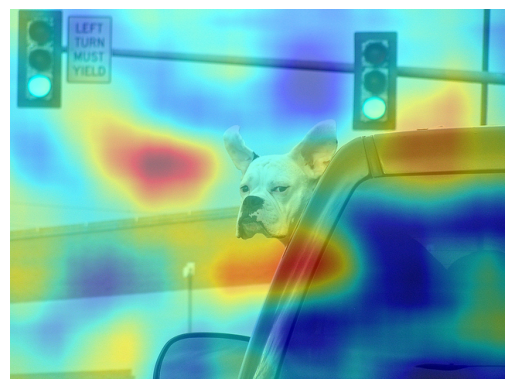

In [15]:
hm_type = 'rise'
hm = generate_hm(hm_type, img, text_embedding, [caption], resize)
c_ret = visualize(hm, img.copy(), resize)
plt.imshow(c_ret)
plt.axis('off')
plt.show()